## Ships Detection in Satellite Imagery

<img src="pic/planet_logo.png" alt="planet_logo" style="float: left; width: 250px;"/>

        Planet Labs Open California Dataset 
        https://www.planet.com/products/open-california/ 
        California Satellite image from October 2013 
        Made available under CC-BY-SA license at a 2 weeks delay from image acquisition
        
        Dataset Source:
        https://www.kaggle.com/rhammell/ships-in-satellite-imagery

        Location of satellite images:
        San Francisco Bay

### Motivation:

In light of the Newspace movement, more and more space startup are established with a goal of providing more frequent data from space down to earth. Commerical space imagery companys like Planet and BlackSky are already supplying daily satellite images to their clients through their fleet of small satellite constellations. As the volume of generated space data increases, new insight and use case can be drawn from the analysis of these images. Thus, there is a need to automate the analysis process through the use of machine learning and image processing technique. The motivation for this capstone project was to address the task of automating the detection of ships from a satellite image dataset so that the large volume of space data can be process quickly and useful information can be extracted to aid in decision making, operation and planning.

Detecting ships in satellite image can potentially provide the following benefits:

    1) Port activity montioring
    2) Supply chain analysis
    3) Sea port operating and logistic planning
    4) Economic forecasting
    
Target audience may include government, hedge fund, maritime company and military to name a few. 

### Goal of Capstone Project:

Main goal of the capstone:

    1) To be able to correctly detect ships in satellite images for a given area of interest in an automatic way.
    
The goal was to create a simple prototype with emphasized place on the machine learning portion of the project. <br>
The area of interest for this project is San Francisco Bay. <br>
Below shows the region of SF Bay that the dataset is generated from. <br>

### Map of San Francisco Bay Area

![SF_Bay_map](pic/SFbay1.png)

### Satellite test image of area of interest

![SF_Bay_img](./ships-in-satellite-imagery/test_v2/sfbay_1.png)

### Method:

The inital idea to go about tackling this problem was to divide it into 2 parts. 

    1) The detection of ships in the image
    2) The classification of ships / not ships
    
I had to find a way to scan through the satellite image and determine if the scan area contains a ship or not. <br>
The second part was a classification problem and any classical machine learning method such as SVM, Logistic Regression and RandomForest could be used. Since I was dealing with images, I chose to use a Convolutional Neural Network (ConvNet) for the classifer as it outperformed the classifical machine learning method in general. However, this comes at the cost of high computation cost, long training time and the requirement of large dataset to train. 

During training, dropout were introduced to regularize the model and prevent it from overfitting.

In the scope of this project, my aim was to build up a prototype quickly and place more emphasize on the machine learning portion of the project. With that in mind, I strive to build a data workflow that will allow me to test different types of CNN architecture for my classifer. Thus, most time was spent on learning, building and tuning different CNN models. For the other parts of the project, solution that can be easily implemented were sought after.

Much of the inspiration of the other parts comes from https://www.pyimagesearch.com.
To scan the satellite image, I used a sliding window function in a fixed size window of 80 by 80 pixel and input the window image to the ConvNet for classification. This is done so to match the training dataset image size used in training. Once a window image is classified as a ship, a green bounding box is drawn. A problem raises in the form of multiple bounding box appearing on the same ships. This is due to the small step size of the sliding window but at the same time we need that small step size to sufficiently scan through the image to search for ships. After some trial and error, a step size of 10 was used. To mitigate this problem, non max suppression method is used to suppress close by bounding box and keep only one. This was quick and dirty and get the job done.

To summarise the script 3 function were generated:

    1) A sliding windows function that scans the larger satellite image
    2) A convolutional neural network classifier to determine if the scan area is a ship or not ship
    3) A non max suppression function to eliminate overlapping of the bounding boxes subject to a threshold
  
The machine learning / deep learning part of the capstone was building and training the ConvNet. I started off testing the ConvNet model from Kaggle and after which, started to look into papers to see other possible architecture that can be tried. The main limiting factor here is the computation resource I have. With more layers, more memory is needed to complie the model and the time taken to train a deeper ConvNet increase significantly. Leveraging on my laptop GPU, I had decided to look for a architecture with a maximum layers of 4. The selected architecture to test was an architecture in < Ying et al 2017> and a 4 block layer VGG like architecture. This will be illustrated later.

### Metrics:

To be able to identify 80% of the ships in the image and reduce as much the chances of a false positive detection. 
(Such as a building detected as ship). Since the test image is actually a full image and not labeled, the verification is done visually. For the classifer, the metric used is the validation accuracy and validation loss of the test set.

### Workflow:

![wf_1](pic/workflow1.png)

### Dataset:

The dataset was sourced from Kaggle and consist of 2800 images with each image been 80 by 80 pixels in 3 channel, RGB.

    1) 700 of the images are labelled as ships ---- Labelled value 1
    2) 2100 of the images are labelled as non ships ---- labelled value 0

The dataset images were cropped from the original Planet Labs orthorectified satellite image within the region of interest. The dataset images were taken from satellite images between 2015-07-18 to 2017-09-25. Any images more current can be used as a test set. These images were freely available to the public under the Open California Program and serve as an ideal source to generate more data and test set for future development of this project. 

The rational of training the model with this dataset was that at different time instance, a different satellite image was generate and can be consider a new data point (image) at that time instance. One limitation of this model is that it was only train from images within the San Francisco Bay. If we were to shift to another new location that contain special feature such as area around Shanghai, we might not be able to use this classifer and instead need to train another model to detect ships in that area by feeding more data into the ConvNet

For a start, only the train images from Kaggle were used.

### Note on Preprocessing

Very little preprocessing is done on the data size except for a simple max RGB value normalization of the pixel values. This is because the ConvNet would do most of the feature extraction from the training images. The reason for normalizing the pixel values was to prevent neurons from saturation (always activated) if a large RGB value is pass to the activation function.

Some possible preprocessing includes:

    1) Mean subraction --> zero center the data
    2) Normalization --> divide by standard deviation of the pixel values or divide by the fixed max value of RGB = 255 (the later is used)


### EDA and preprocessing

In [1]:
## Import library to be used

## standard DS library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import random
import time
import pickle

## sklearn
from sklearn.utils import shuffle

## json
import json

## image processing library
import cv2
from PIL import Image

## Keras + Tensorflow
import keras
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
## Load json dataset
f = open(r'./ships-in-satellite-imagery/shipsnet_v2.json')
dataset = json.load(f)
f.close()

In [3]:
type(dataset)

dict

In [4]:
dataset.keys()

dict_keys(['scene_ids', 'labels', 'locations', 'data'])

The dataset comes in the json format. A brief description of the dictionary keys is found below:

    scene_ids: unique ID of a images from Planet Labs.
    label: label of ships or not ships. ships class has value 1 and non ships class has value 0
    location: A list of longtitude and latitude coordinates of the sampled image clip. [long, lat]
    data: A list of pixel value of image. Each image is a list of len = 19200. 
    
    For data, the picture below depicts how an image can be form from the data list of pixel values.
    

<img src="pic/datapixel.png" alt="Drawing" style="width: 600px;"/>

In [5]:
## convert to dataframe to conduct EDA
df= pd.DataFrame(dataset)
df.head()

data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005  
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f  
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a  
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b  
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
data         2800 non-null object
labels       2800 non-null int64
locations    2800 non-null object
scene_ids    2800 non-null object
dtypes: int64(1), object(3)
memory usage: 87.6+ KB


In [7]:
df.shape

(2800, 4)

In [8]:
### data type ['labels'] for each image is int64 -> convert to int8
### take up lesser memory and RGB values only range from 0 to 255

df['labels'] = np.array(df['labels']).astype('uint8')
print(type(df['labels'][0]))

<class 'numpy.uint8'>


In [9]:
### data type ['locations'] for each image is a list of float for lat and long
print(type(df.locations[0][0]))
print(type(df.locations[0][1]))

## Extracting Lat Long information
df['longtitude'] = df.locations.map(lambda x: x[0])
df['latitude'] = df.locations.map(lambda x: x[1])

df.head()

<class 'float'>
<class 'float'>


data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  longtitude  \
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005 -122.342705   
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f -122.349756   
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a -122.349084   
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b -122.326131   
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c -122.333229   

    latitude  
0  37.750586  
1  37.769796  
2  37.749351  
3  37.738163  
4  37.721168

In [10]:
### data type ['scene_ids'] for each image is a string
print(type(df.scene_ids[0]))

### Example scene ids: 20170501_180618_1005
### 20170501 --- date of image
### 180618 --- time of image (in UTC)
### 1005 --- sat_id

# Extract these date, time and sat_id out
df['date']=df.scene_ids.map(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8])
df['time_UTC']=df.scene_ids.map(lambda x: x[9:11] + ':' + x[11:13] + ':' + x[13:15])
df['sat_id']=df.scene_ids.map(lambda x: x[16:20])

df.head()

<class 'str'>


data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  longtitude  \
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005 -122.342705   
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f -122.349756   
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a -122.349084   
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b -122.326131   
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c -122.333229   

    latitude        date  time_UTC sat_id  
0  37.750586  2017-05-01  18:06:18   1005  
1  37.769796  2017-05-01  18:13:20   0e1f  
2  37.749351  2017-06-09  18:07:56   103a  
3  37.738163  2017-07-21  18:08:25   100b  
4  37.721168  2017-07-02  18:09:43   103c

In [11]:
## Extracting R,G,B channel

R = []
G = []
B = []

for i, v in enumerate(df.data):
    R.append(v[0:6400])
    G.append(v[6400:12800])
    B.append(v[12800:19200])

df['R'] = R
df['G'] = G
df['B'] = B

In [12]:
print (len(df.R[0]))
print (len(df.B[0]))
print (len(df.G[0]))

6400
6400
6400


In [13]:
df.head()

data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  longtitude  \
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005 -122.342705   
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f -122.349756   
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a -122.349084   
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b -122.326131   
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c -122.333229   

    latitude        date  time_UTC sat_id  \
0  37.750586  2017-05-01  18:06:18   1005   
1  37.769796  2017-05-01  18:13:20   0e1f   
2  37.749351  2017-06-09  18:07:56   103a   
3  37.738163  2017-07-21  18:08:25   100b   
4  37.721168  2017-07-02  18:09:43   103c   

                                                   R  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...   

                                                   G  \
0  [49, 47, 48, 50, 51, 51, 50, 49, 52, 49, 41, 4...   
1  [41, 39, 45, 44, 38, 33, 39, 36, 36, 45, 37, 3...   
2  [113, 112, 106, 105, 107, 108, 111, 112, 106, ...   
3  [82, 84, 84, 83, 84, 84, 85, 84, 84, 85, 84, 8...   
4  [73, 69, 68, 72, 76, 77, 79, 72, 63, 73, 79, 7...   

                                                   B  
0  [36, 35, 35, 37, 36, 36, 35, 35, 38, 36, 28, 3...  
1  [43, 41, 47, 46, 39, 35, 44, 39, 38, 49, 39, 3...  
2  [91, 90, 85, 83, 86, 87, 90, 91, 87, 101, 100,...  
3  [66, 69, 67, 63, 63, 64, 66, 64, 63, 63, 62, 6...  
4  [58, 57, 55, 58, 61, 63, 65, 59, 51, 58, 61, 5...

In [14]:
### number of unique satellite image
df.scene_ids.nunique()

284

In [15]:
## For future search and data mining of more 80 by 80 pixel dataset
## save the list of unique scene id in a csv file
dl_planet = df.scene_ids.value_counts()
dl_planet.to_csv('./preprocessing/scene_ids.csv')
print (type(dl_planet))

<class 'pandas.core.series.Series'>


In [16]:
## Calculate the mean, standard deviation and range of R, G and B in each image for used in image normalization.
## However this is for practice and would not be used in the final input to train the ConvNet.
## Only a simple division of the 

In [17]:
r_mean = []
r_std = []
r_range = []

for i,v in enumerate(df.R):
    r_mean.append(np.mean(v))
    r_std.append(np.std(v))
    r_range.append(max(v)-min(v))

df['r_mean'] = r_mean
df['r_std'] = r_std
df['r_range'] = r_range

b_mean = []
b_std = []
b_range = []

for i,v in enumerate(df.B):
    b_mean.append(np.mean(v))
    b_std.append(np.std(v))
    b_range.append(max(v)-min(v))

df['b_mean'] = b_mean
df['b_std'] = b_std
df['b_range'] = b_range

g_mean = []
g_std = []
g_range = []

for i,v in enumerate(df.G):
    g_mean.append(np.mean(v))
    g_std.append(np.std(v))
    g_range.append(max(v)-min(v))

df['g_mean'] = g_mean
df['g_std'] = g_std
df['g_range'] = g_range

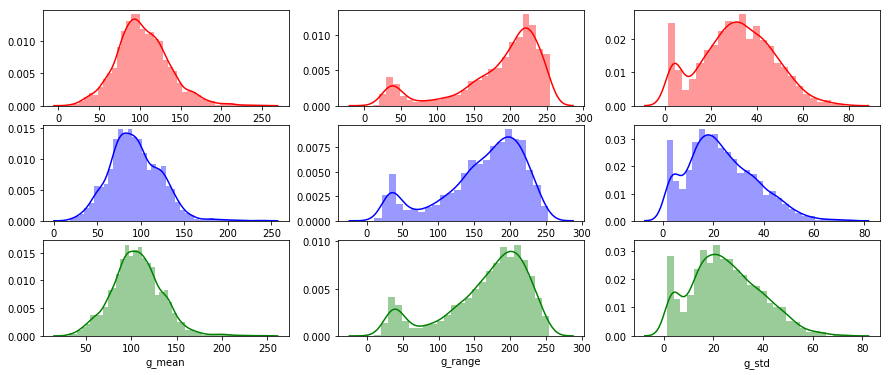

In [18]:
### distribution plots of mean, range and std for r,g,b channel 
## for every image in out data set


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
sns.distplot(df.r_mean, color = 'r', ax=ax[0,0])
sns.distplot(df.r_range, color = 'r', ax=ax[0,1])
sns.distplot(df.r_std, color = 'r', ax=ax[0,2])
sns.distplot(df.b_mean, color = 'b', ax=ax[1,0])
sns.distplot(df.b_range, color = 'b', ax=ax[1,1])
sns.distplot(df.b_std, color = 'b', ax=ax[1,2])
sns.distplot(df.g_mean, color = 'g', ax=ax[2,0])
sns.distplot(df.g_range, color = 'g', ax=ax[2,1])
sns.distplot(df.g_std, color = 'g', ax=ax[2,2])

Looks pretty even and not much info can be derive from this.

In [19]:
df.head()

data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  longtitude  \
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005 -122.342705   
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f -122.349756   
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a -122.349084   
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b -122.326131   
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c -122.333229   

    latitude        date  time_UTC sat_id  \
0  37.750586  2017-05-01  18:06:18   1005   
1  37.769796  2017-05-01  18:13:20   0e1f   
2  37.749351  2017-06-09  18:07:56   103a   
3  37.738163  2017-07-21  18:08:25   100b   
4  37.721168  2017-07-02  18:09:43   103c   

                                                   R   ...     \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...   ...      
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...   ...      
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...   ...      
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...   ...      
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...   ...      

                                                   B      r_mean      r_std  \
0  [36, 35, 35, 37, 36, 36, 35, 35, 38, 36, 28, 3...   61.083594  53.082336   
1  [43, 41, 47, 46, 39, 35, 44, 39, 38, 49, 39, 3...   38.800938  44.005728   
2  [91, 90, 85, 83, 86, 87, 90, 91, 87, 101, 100,...  111.536094  24.178780   
3  [66, 69, 67, 63, 63, 64, 66, 64, 63, 63, 62, 6...   83.433437  29.240890   
4  [58, 57, 55, 58, 61, 63, 65, 59, 51, 58, 61, 5...  111.945625  71.662371   

   r_range      b_mean      b_std  b_range      g_mean      g_std  g_range  
0      253   42.607656  25.129844      239   58.644688  30.261728      245  
1      253   47.699844  28.502265      248   48.032187  31.209487      250  
2      242   90.942188  17.159903      203  110.150469  18.907646      216  
3      223   71.906406  22.692492      193   90.761250  23.356956      207  
4      222  105.105469  72.642569      223  119.188281  70.323569      213  

[5 rows x 21 columns]

In [20]:
## save this dataframe for future reference
df.to_pickle('preprocessing/preprocessed_df.pkl')

### End of EDA

### Input data preparation for training ConvNet

Initially I trained my model without shuffling the dataset. When training ConvNet, the test accuracy and loss were oscillating and not converging into a single value. This was due to the fact the I did not randomly shuffle the image data and the test set extracted via keras model.fit validation_split of 80/20 just took the last 20% of the data as test set which are all image labelled 0 (non-ship). Therefore, the resulting accuracy and loss from the training were oscillating as the ConvNet tries to predict the image but all their label are the same. 

Hence, the dataset was shuffle here before normalization.

In [21]:
test_df = pd.DataFrame(dataset)

## location and scene ids not needed
test_df = test_df.drop(['locations','scene_ids'], axis=1)

In [22]:
test_df.head(10)

data  labels
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1
5  [136, 136, 132, 133, 136, 129, 126, 128, 134, ...       1
6  [99, 94, 86, 91, 99, 96, 102, 103, 95, 97, 100...       1
7  [77, 76, 77, 75, 70, 77, 80, 78, 76, 76, 78, 7...       1
8  [68, 75, 68, 61, 65, 73, 67, 61, 63, 67, 63, 6...       1
9  [134, 134, 136, 134, 133, 136, 137, 136, 137, ...       1

In [23]:
## note that only 25% of the dataset are ships

test_df = shuffle(test_df)
test_df.head(10)

data  labels
854   [173, 159, 135, 113, 104, 112, 122, 127, 134, ...       0
1080  [104, 98, 97, 102, 99, 94, 96, 108, 105, 104, ...       0
2247  [120, 123, 119, 116, 118, 124, 124, 119, 115, ...       0
1616  [32, 33, 32, 32, 35, 32, 31, 35, 37, 35, 36, 4...       0
1742  [69, 70, 71, 71, 66, 69, 74, 74, 69, 73, 75, 7...       0
1031  [97, 99, 97, 99, 101, 97, 94, 96, 100, 98, 103...       0
2084  [82, 77, 77, 79, 81, 84, 81, 80, 80, 80, 90, 8...       0
1331  [85, 83, 78, 75, 81, 82, 79, 81, 80, 79, 80, 7...       0
1770  [128, 131, 132, 128, 122, 127, 130, 131, 134, ...       0
250   [133, 141, 144, 143, 141, 139, 140, 141, 142, ...       1

In [24]:
data = list(test_df.data)
data = np.array(data).astype('uint8')

In [25]:
labels = list(test_df['labels'])
labels = np.array(labels).astype('uint8')

### Normalization with fixed RGB value

In [26]:
print(data.shape)
print(labels.shape)

(2800, 19200)
(2800,)


In [27]:
data

array([[173, 159, 135, ..., 107,  79,  69],
       [104,  98,  97, ...,  93,  89,  81],
       [120, 123, 119, ...,  97,  94,  94],
       ..., 
       [101,  99,  97, ...,  74,  71,  68],
       [109, 108, 109, ..., 109, 112, 115],
       [194, 193, 188, ..., 157, 154, 158]], dtype=uint8)

In [28]:
labels

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [29]:
## original data with no normalization

orig = data.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print (orig.shape)

(2800, 80, 80, 3)


In [30]:
### normalize data by max value of 255 for RGB.
### RGB - 0 - 255

x = data / 255.
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print(x.shape)

(2800, 80, 80, 3)


In [31]:
#### categorical label output
## ship -> [0, 1]
## non ship -> [1, 0]
y = to_categorical(labels, num_classes=2)
print(y.shape)

(2800, 2)


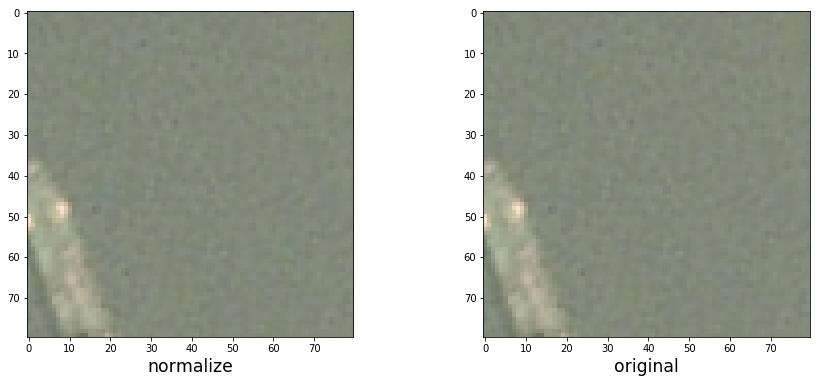

In [32]:
## visually see what normalization does
im1 = x[8,:,:,:]
im2 = orig[8,:,:,:]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax[0].imshow(im1)
ax[0].set_xlabel('normalize', size= 'xx-large')
ax[1].imshow(im2)
ax[1].set_xlabel('original', size= 'xx-large')
plt.show()

## Since imshow automatically converts the RGB value to a value between [0,1]
## before mapping to a colormap, both will turn out to be the same

In [33]:
ship = test_df[test_df['labels'] == 1]
nship = test_df[test_df['labels'] != 1]

In [34]:
ship_d = list(ship.data)
ship_d = np.array(ship_d).astype('uint8')

In [35]:
ship_d = ship_d.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])

In [36]:
ship_d.shape

(700, 80, 80, 3)

### Take a look at the dataset

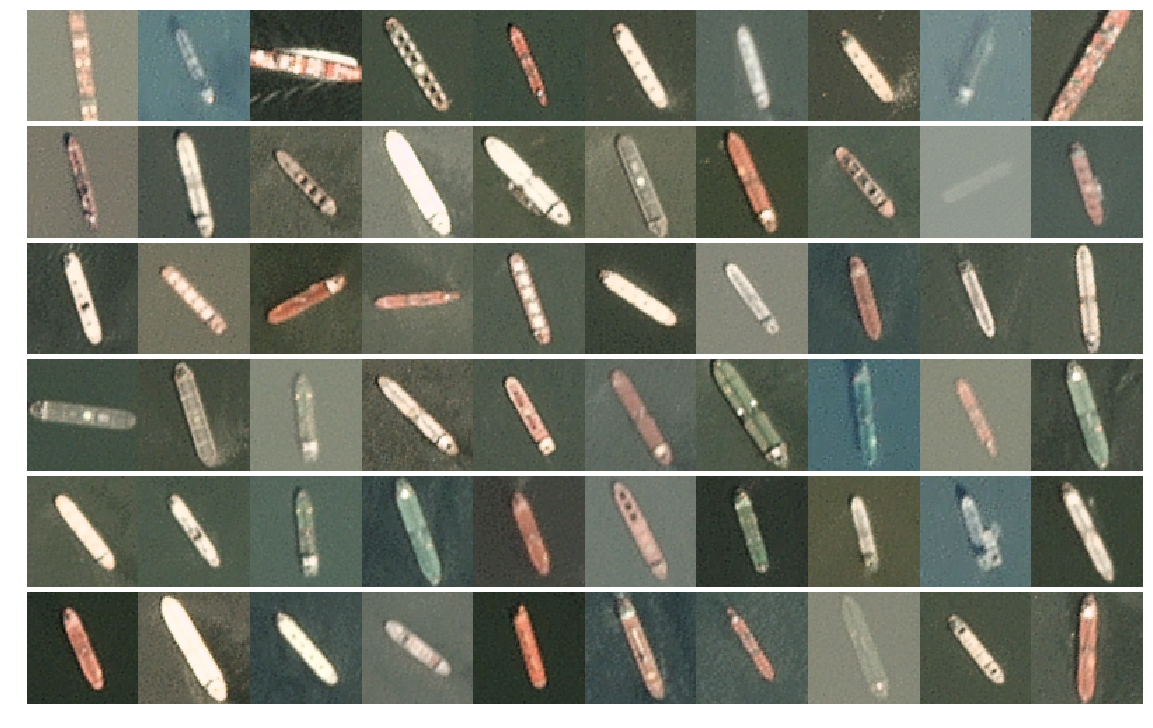

In [37]:
## display first 60 pic 

ship_60 = ship_d[0:60,:,:,:]

plt.figure(figsize=(20,15))
columns = 10
for i, image in enumerate(ship_60):
    plt.subplot(len(ship_60) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.subplots_adjust(hspace=0)

data images with label ships have images of ship centered in the images frame

In [38]:
nship_d = list(nship.data)
nship_d = np.array(nship_d).astype('uint8')

In [39]:
nship_d = nship_d.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])

In [40]:
nship_d.shape

(2100, 80, 80, 3)

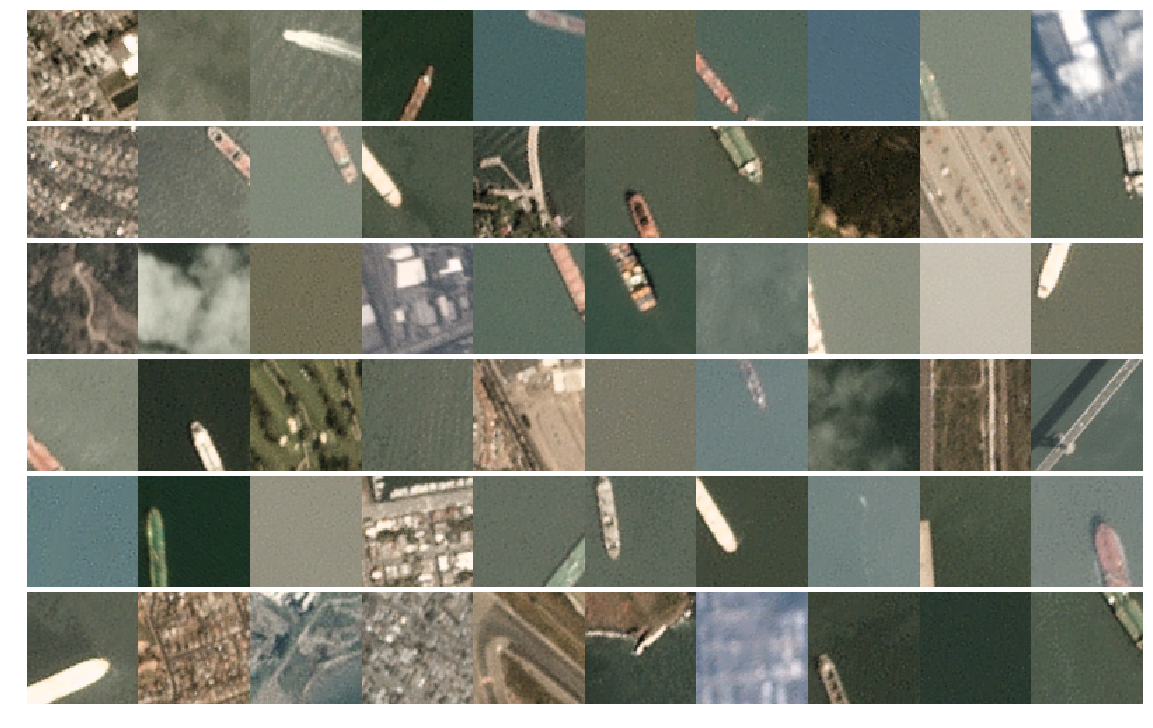

In [41]:
## display first 60 pic 

nship_60 = nship_d[0:60,:,:,:]

plt.figure(figsize=(20,15))
columns = 10
for i, image in enumerate(nship_60):
    plt.subplot(len(nship_60) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.subplots_adjust(hspace=0)

Non ship images include the landcover features such as water, vegetation, buildings, bare land, harbour edge and partial ship to bias the ConvNet telling it not to identify ship if its just a partial ship.

### Using x,y as training dataset

## ConvNet

2 ConvNet architecture was trained and the performance tested. One was from Kaggle and was used as an initial attempt to learn how to use keras. The 2nd architecture was derived from a paper by Ying LIU et al (2017).

![paper](pic/paper.png)

### Classifer 1
Architecture

Basically a VGG like ConvNet using double convolutional layer before max pooling and had been shown to perform really well, even when there is only 2 block layer used here. Wiht the double layer activation ReLU, it discriminate the image more and allow for more feature extracted before max pooling.

In [2]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy'])

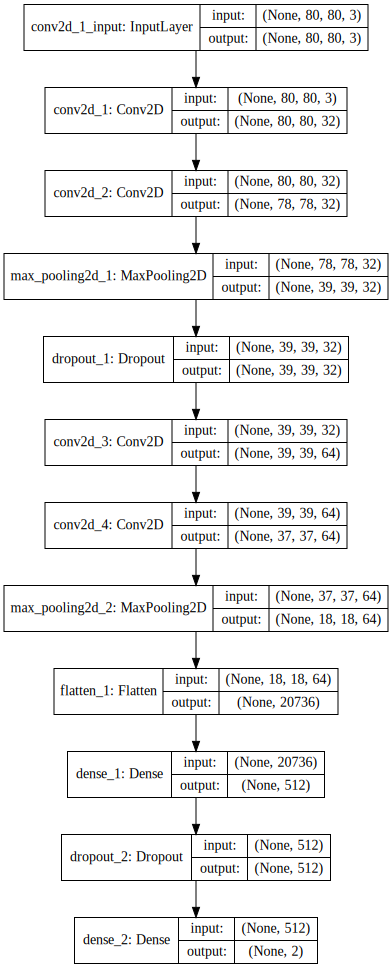

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model1,show_shapes=True, rankdir ='TB').create(prog='dot', format='svg'))


### Classifer 2
Architecture

The architecture differ in that there is only 1 convolutional layer before each max pooling. However, the convolutional layer feature maps increase with every layer as the ConvNet goes deeping. 

In [4]:
## Dropout was put following the way it was implemented in Kaggle

## Start of model
model2 = Sequential()

model2.add(Conv2D(64, (5, 5), padding="valid", input_shape=(80, 80, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (5, 5), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Dropout(0.5))

model2.add(Conv2D(256, (3, 3), padding="valid", activation='relu'))

model2.add(Conv2D(384, (3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

## FC layer 1
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))

model2.add(Dropout(0.5))

model2.add(Dense(2, activation='softmax'))

## compile a model
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy'])

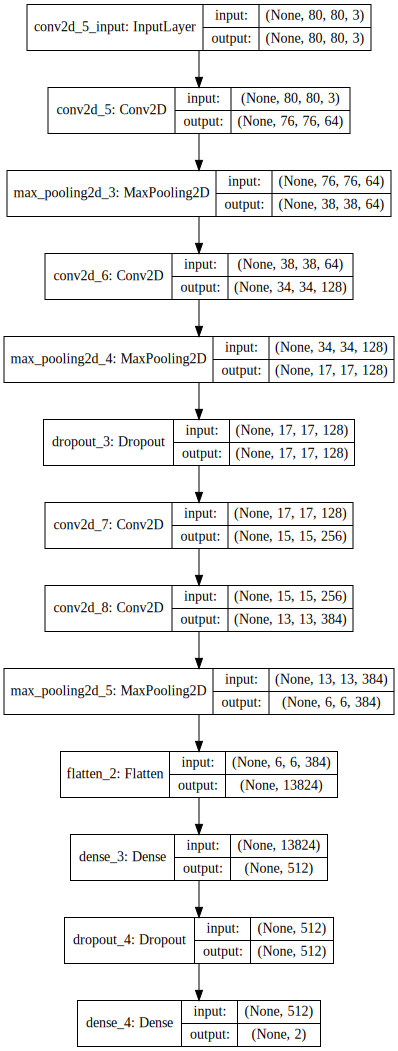

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model2,show_shapes=True, rankdir ='TB').create(prog='dot', format='svg'))


Both compilation setting were keep the same and uses the same SGD optimizer to allow comparsion of the 2 model.

## Train the model
Expected long waiting time.........

In [56]:
train_start1 = time.time()

history1 = model1.fit(x, y, batch_size=64, epochs=150, validation_split=0.2)

train_end1 = time.time()

Train on 2240 samples, validate on 560 samples
Epoch 1/150
2240/2240 [==============================] - 22s - loss: 0.5025 - acc: 0.7853 - val_loss: 0.3329 - val_acc: 0.8714
Epoch 2/150
2240/2240 [==============================] - 13s - loss: 0.2720 - acc: 0.8902 - val_loss: 0.2204 - val_acc: 0.9000
Epoch 3/150
2240/2240 [==============================] - 13s - loss: 0.2096 - acc: 0.9147 - val_loss: 0.1869 - val_acc: 0.9125
Epoch 4/150
2240/2240 [==============================] - 13s - loss: 0.1767 - acc: 0.9344 - val_loss: 0.1699 - val_acc: 0.9304
Epoch 5/150
2240/2240 [==============================] - 13s - loss: 0.1459 - acc: 0.9424 - val_loss: 0.1119 - val_acc: 0.9589
Epoch 6/150
2240/2240 [==============================] - 13s - loss: 0.1075 - acc: 0.9625 - val_loss: 0.1077 - val_acc: 0.9589
Epoch 7/150
2240/2240 [==============================] - 13s - loss: 0.0919 - acc: 0.9683 - val_loss: 0.0716 - val_acc: 0.9732
Epoch 8/150
2240/2240 [==============================] - 13s - l

2240/2240 [==============================] - 16s - loss: 3.7634e-05 - acc: 1.0000 - val_loss: 0.1027 - val_acc: 0.9875
Epoch 127/150
2240/2240 [==============================] - 16s - loss: 7.9985e-05 - acc: 1.0000 - val_loss: 0.1011 - val_acc: 0.9893
Epoch 128/150
2240/2240 [==============================] - 16s - loss: 2.5523e-05 - acc: 1.0000 - val_loss: 0.1008 - val_acc: 0.9893
Epoch 129/150
2240/2240 [==============================] - 16s - loss: 2.6488e-05 - acc: 1.0000 - val_loss: 0.1013 - val_acc: 0.9893
Epoch 130/150
2240/2240 [==============================] - 16s - loss: 3.2883e-05 - acc: 1.0000 - val_loss: 0.1015 - val_acc: 0.9893
Epoch 131/150
2240/2240 [==============================] - 16s - loss: 2.8206e-05 - acc: 1.0000 - val_loss: 0.1017 - val_acc: 0.9893
Epoch 132/150
2240/2240 [==============================] - 16s - loss: 2.2345e-05 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9893
Epoch 133/150
2240/2240 [==============================] - 16s - loss: 2.0934e-05 -

In [61]:
train_time1 = train_end1 - train_start1
print ('Classifer 1 model train time = {} mins'.format(train_time1/60))

Classifer 1 model train time = 39.212416835625966 mins


In [58]:
train_start2 = time.time()

history2 = model2.fit(x, y, batch_size=64, epochs=150, validation_split=0.2)

train_end2 = time.time()

Train on 2240 samples, validate on 560 samples
Epoch 1/150
2240/2240 [==============================] - 32s - loss: 0.4864 - acc: 0.7879 - val_loss: 0.3561 - val_acc: 0.8589
Epoch 2/150
2240/2240 [==============================] - 26s - loss: 0.2960 - acc: 0.8835 - val_loss: 0.2571 - val_acc: 0.8946
Epoch 3/150
2240/2240 [==============================] - 26s - loss: 0.2356 - acc: 0.9027 - val_loss: 0.2235 - val_acc: 0.9089
Epoch 4/150
2240/2240 [==============================] - 26s - loss: 0.2138 - acc: 0.9121 - val_loss: 0.2166 - val_acc: 0.9054
Epoch 5/150
2240/2240 [==============================] - 26s - loss: 0.2044 - acc: 0.9192 - val_loss: 0.1941 - val_acc: 0.9143
Epoch 6/150
2240/2240 [==============================] - 26s - loss: 0.1821 - acc: 0.9263 - val_loss: 0.1753 - val_acc: 0.9268
Epoch 7/150
2240/2240 [==============================] - 26s - loss: 0.1702 - acc: 0.9277 - val_loss: 0.1658 - val_acc: 0.9375
Epoch 8/150
2240/2240 [==============================] - 26s - l

2240/2240 [==============================] - 26s - loss: 0.0033 - acc: 0.9987 - val_loss: 0.0349 - val_acc: 0.9946
Epoch 128/150
2240/2240 [==============================] - 26s - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0300 - val_acc: 0.9893
Epoch 129/150
2240/2240 [==============================] - 26s - loss: 0.0034 - acc: 0.9982 - val_loss: 0.0415 - val_acc: 0.9911
Epoch 130/150
2240/2240 [==============================] - 26s - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0393 - val_acc: 0.9929
Epoch 131/150
2240/2240 [==============================] - 26s - loss: 0.0160 - acc: 0.9964 - val_loss: 0.0505 - val_acc: 0.9857
Epoch 132/150
2240/2240 [==============================] - 26s - loss: 0.0133 - acc: 0.9946 - val_loss: 0.0651 - val_acc: 0.9893
Epoch 133/150
2240/2240 [==============================] - 26s - loss: 0.0092 - acc: 0.9969 - val_loss: 0.0326 - val_acc: 0.9875
Epoch 134/150
2240/2240 [==============================] - 26s - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0303 

In [62]:
train_time2 = train_end2 - train_start2
print ('Classifer 2 model train time = {} mins'.format(train_time2/60))

Classifer 2 model train time = 66.99689031442007 mins


Save data and training history

In [70]:
with open('./cnn_model/capstoneP4/model1_hist.pkl', 'wb') as file_name:
    pickle.dump(history1.history, file_name)

In [71]:
with open('./cnn_model/capstoneP4/model2_hist.pkl', 'wb') as file_name:
    pickle.dump(history2.history, file_name)

In [72]:
model1.save('./cnn_model/capstoneP4/model1.h5')

In [73]:
model2.save('./cnn_model/capstoneP4/model2.h5')

### Result Analysis

Load Model

In [4]:
with open('./cnn_model/capstoneP4/model1_hist.pkl','rb') as file_name:
    model1_hist = pickle.load(file_name)

In [5]:
with open('./cnn_model/capstoneP4/model2_hist.pkl','rb') as file_name:
    model2_hist = pickle.load(file_name)

In [76]:
model1 = load_model('./cnn_model/capstoneP4/model1.h5')

In [77]:
model2 = load_model('./cnn_model/capstoneP4/model2.h5')

### Plot accuracy and loss for train and test set over all epoch

In [6]:
## different classification determine the way accuracy is calculated.
## default is categorical_accuracy as we had set our labels as [1,0] and [0,1]
## if our labels are just 1 and 0, we should use binary_accuracy

print('accuracy of classifer 1 = {}'.format(model1_hist['val_acc'][-1]))
print('loss of classifer 1 = {}'.format(model1_hist['val_loss'][-1]))

accuracy of classifer 1 = 0.9875000068119594
loss of classifer 1 = 0.10168536440635632


In [7]:
print('accuracy of classifer 2 = {}'.format(model2_hist['val_acc'][-1]))
print('loss of classifer 2 = {}'.format(model2_hist['val_loss'][-1]))

accuracy of classifer 2 = 0.9928571496691022
loss of classifer 2 = 0.04778829952868234


Both classifer 1 and 2 achieve really high accuracy with the test set but there seem to be sign of over fitting for both classifer 2 as the validation loss is higher then the training loss. To determine if overfitting really occur, the classifer is used with the sliding windows to test the detection of ships

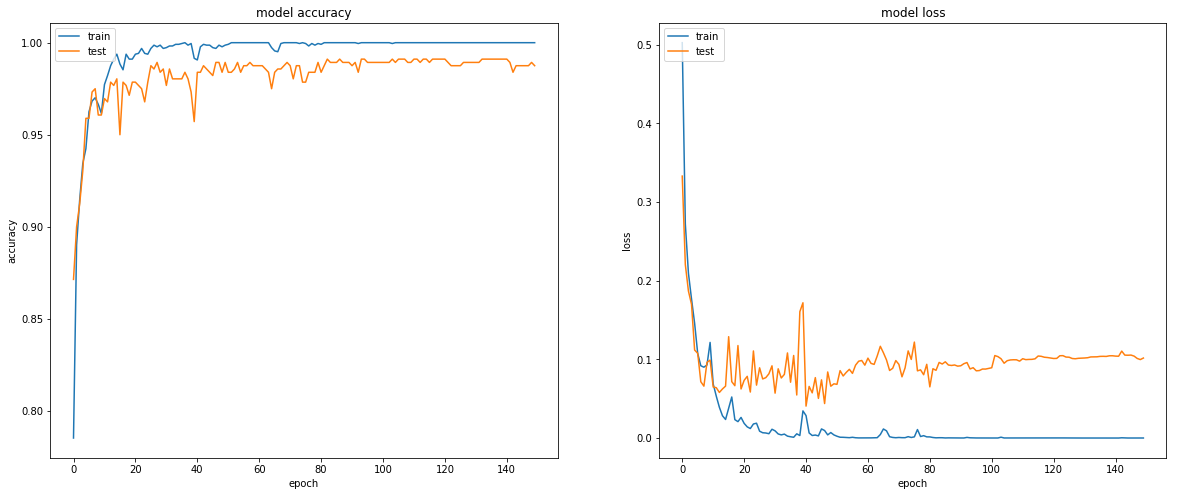

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax[0].plot(model1_hist['acc'])
ax[0].plot(model1_hist['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(model1_hist['loss'])
ax[1].plot(model1_hist['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

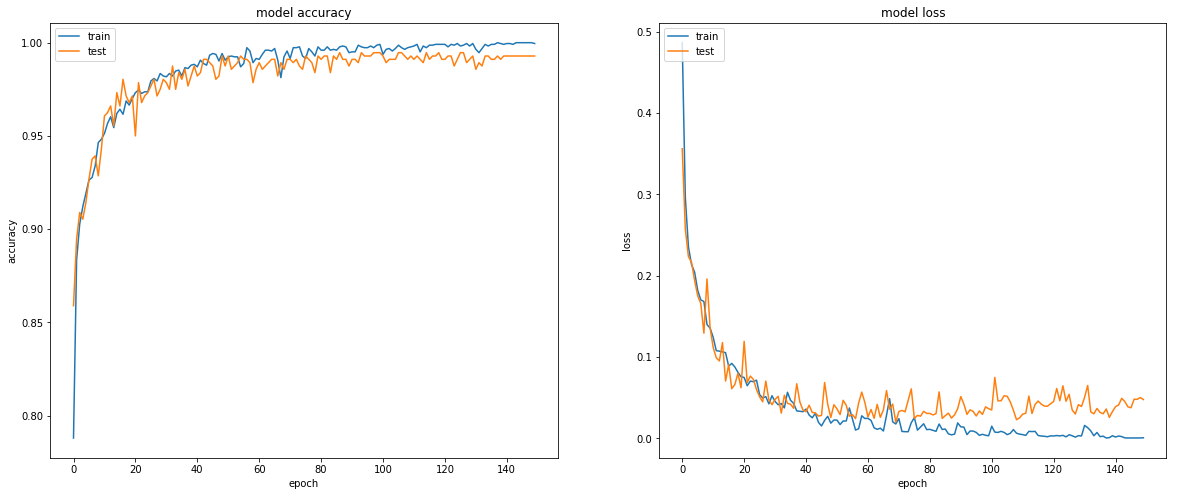

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax[0].plot(model2_hist['acc'])
ax[0].plot(model2_hist['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(model2_hist['loss'])
ax[1].plot(model2_hist['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

### Problems with Training and ConvNet in General that I encountered

    1) Shuffle data if the data is sorted! Initially my train accuracy was smooth but test accuracy was oscillating and do not converge which give indication that there is something wrong with the test. Plotting the accuracy and loss metric can be use to debug the training
    2) Since training takes a very long time, tested with short epoch first (20 epoch) to see if the training converge.
    3) More dropout does not necessary give good regularization. At first I thought dropout should be on each layers of the convolution -- maxpool layer but it turns out dropout should be done in deeper stage of the ConvNet. I guess the intuition is that the Convolution layers can extract the feature first before regularization.
  
Overfitting is a major issue in this ConvNet due to the limited training set although it is kept at a minimum due to the shallow ConvNet used.

To tackle this problem dropout regularization was used.

Things that I had yet to try
- Data Augumentation --- doing rotation, translational, skewing etc
- Negative mining --- in progress, tedious and hand labelled data
- Batch normalization
- Decaying learning  -- done
- Adam optimizer -- done

## Testing on the large satellite image

### Sliding Window Function

In [94]:
def sliding_window(image, stepsize , winsize):
    
    """iterate a image window specifiy by window size and step size over the entire input image by pixels

    Args:
        
        ## y = height of image, x = width of image
        
        image: input image to iterate the sliding window.        
        stepsize: no. of pixel shift for each step in a tuple (y, x).
        winsize: pixel size of the window in a tuple (y, x).
        
    Returns:
        
        1) Top left pixel x,y cooridinates of the window
        2) bottem righ pixel x,y cooridinates of the window
        3) Image within the window
    """

    
def sliding_window(image, stepsize , winsize):
    # image is always specify by height first then width
    
    # slide a window across the satellite image
    for y in range(0, image.shape[0], stepsize[0]):
        for x in range(0, image.shape[1], stepsize[1]):
            # yield to generate the coordinates and window image for use in the classifier
            # as we scan through the image
            yield (x, y, x + winsize[1], y + winsize[0], image[y:y + winsize[0], x:x + winsize[1]])

In [95]:
def non_max_suppression(bound_box, area_overlap_threshold):
    
        
    """For a list of bounding box, suppress nearby bounding box by
       thresholding the overlapping area

    Args:
        
        bound_box: list of tuples contain top left coordinate (x1,y1) 
                   and bottom right coordinate (x2,y2) of the bounding box
                   Example: [(x1,y1,x2,y2), (..., ..., ..., ...), .....]
        
        area_overlap_threshold: overlap area ratio between 2 box.
                                0.5 will mean overlaping by half of the box area
    Returns:
        
        list of pick boxes coordinates in a list of tuples
    """
    
    # bound_box => np.array of bounding box coordinate[(x1,y1,x2,y2),(),()] for numpy slicing
    boxes = np.array(bound_box)
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize a list for pick boxes coordinates
    pick = []
 
    # x1, y1 top left point of each bounding box
    # x2, y2 bottem right point of each bounding box
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
   
    # Default bounding box area is the same as the search window --> 80*80 == 6400
    area = 6400.0
    
    # Sort the index of the bounding boxes by y2 (bottem right)
    ind = np.argsort(y2)
 
    while len(ind) > 0:
        end = len(ind) - 1
        i = ind[end] # get the last index of the ind list for coordinates (x1,y1,x2,y2)
        pick.append(i) # pick the last bounding box in the list (bottom right most bounding box in the full sat image)
        suppress = [end] # place the index of last bounding box in suppress
        
        # At the end of each for loop, the index of last bounding box will be deleted from ind list 
        # as it is already been place in the pick list
        
        # Each loop will try to find neighbouring boxes with high overlapping area with the last bounding box in the list
        # Once found, suppress these neighbouring boxes and only keep the bottom right most
        
        for coord in range(0, end):
            j = ind[coord]
            # Loop through all the remaining bounding boxes in ind list
            
            # find the largest (x, y) coordinates for the start of the bounding box
            # find smallest (x, y) coordinates for the end of the bounding box
            
            # This is used to calculate the overlapping area
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            
            # Note that the min, max selection of coordinates is with reference to the last bounding box in the image
            # x[i] is the last bounding box with the highest x1,y1,x2,y2 value when compared to non-overlapping boxes.
            # Therefore:
            
            # xx2 - xx1 will be negative and w = 0
            # yy2 - yy1 will be positive and h = 0
            
            # if there is no overlapping of the boxes i, j.
        
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap
            # Bounding box area is only 1 size of area 6400
            overlap = (w * h) / area
        
            # check if the overlap ratio exceed a certain value. 
            # if so, put it into the suppress list
            if overlap > area_overlap_threshold:
                suppress.append(coord)
 
        # delete all index in suppress list from ind list.
        ind = np.delete(ind, suppress)
 
    return boxes[pick]

### Initiate 

In [98]:
satimage_scan = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
satimage_result = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
satimage_nms = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
print (satimage_scan.shape[0])
print (satimage_scan.shape[1])

1777
2825


Set window size to 80 by 80
Set step size to 10 in x direction and 10 in y direction. 
This is found to work the best

In [99]:
(winH, winW) = (80, 80)
(stepY,stepX) = (10, 10)

### Try with Classifer 1
input the large satellite image for scanning

### Scanning in action!!

![scan_gif](./results/capstoneP4/gif1/gif1.gif)

In [100]:
# loop sliding window over the enitre satellite image

# initiate list to safe some result during the scan

ship_pred_class = [] # predict class from the model
ship_img = [] # window image
ship_cooridinate = [] # window coordinates

i = 0

## time for the sliding window to scan the whole satellite image
scan_start = time.time()

for (x1, y1, x2, y2, window) in sliding_window(satimage_scan, stepsize=(stepY,stepX), winsize=(winH, winW)):
    
    # If the window does not meet our desired window size, continue 
    # For windows reaching the edge, ignoring those windows not the same size as the specified winsize)
    
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    # Classifier Code
    # Classify content within the sliding window
    # input a new dims on the window so that it can be input into the CNN classifier (take in only a tensor)
    target_region = np.expand_dims(window, axis=0)
    classes = model1.predict_classes(target_region)
    
    # classes [0] = 1 is ship
    # classes [0] = 0 is not ship
    
    if classes[0] == 1:
        
        # save the identified window to verfiy later
        cv2.imwrite("./results/capstoneP4/winimg1/rimg_{}.png".format(i), window)
        
        # save the coordinates and window image in a dictionary
        ship_pred_class.append(classes[0])
        ship_img.append(window)
        ship_cooridinate.append((x1,y1,x2,y2))
        
        # cv2.namedWindow("Window", cv2.WINDOW_NORMAL) 
        # draw a rectange green box at the pixel coordinate (x, y) and (x + winW, y + winH) with box line thickness of 2 pixel
        cv2.rectangle(satimage_result, (x1, y1), (x1 + winW, y1 + winH), (0, 255, 0), 2) 
        #cv2.imshow("Windows",satimage)
        
        # Save the big satellite image for gif generation
        cv2.imwrite("./results/capstoneP4/gif1/img_{}.png".format(i), satimage_result)
        
        # Save the window image that has a bounding box
        
        i += 1
        
        # use this for visual debugging
        
        #cv2.waitKey(1)
        #time.sleep(0.025)
    #else:
        #cv2.waitKey(1)
        #time.sleep(0.025)


# Final result of satimage_result
# Everytime satimage_result will update with more green boxes
cv2.imwrite("./results/capstoneP4/final_result/detected1.png", satimage_result)
cv2.destroyAllWindows()
                          
scan_end = time.time()
scan_time = scan_end - scan_start

print(scan_time)

print('-------------------')

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s
385.1788671016693
-------------------


In [101]:
## Save the dictionary for future reference

In [103]:
predict_ship1 = {'ship_pred_class': ship_pred_class, 'ship_img': ship_img, 'ship_cooridinate': ship_cooridinate}
    
with open('./results/capstoneP4/final_result/predict_ship1.pkl', 'wb') as file_name:
    pickle.dump(predict_ship1, file_name)

In [105]:
with open('./results/capstoneP4/final_result/predict_ship1.pkl','rb') as file_name:
    test_ship = pickle.load(file_name)

In [107]:
test_ship_df = pd.DataFrame(test_ship)
test_ship_df.head()

ship_cooridinate                                           ship_img  \
0   (830, 0, 910, 80)  [[[75, 90, 82], [74, 89, 80], [74, 89, 79], [7...   
1   (840, 0, 920, 80)  [[[70, 85, 74], [73, 88, 77], [70, 86, 75], [6...   
2   (850, 0, 930, 80)  [[[67, 82, 72], [69, 84, 74], [70, 85, 74], [7...   
3  (810, 10, 890, 90)  [[[136, 155, 165], [112, 130, 134], [84, 101, ...   
4  (820, 10, 900, 90)  [[[78, 94, 85], [79, 94, 87], [74, 90, 84], [6...   

   ship_pred_class  
0                1  
1                1  
2                1  
3                1  
4                1

In [109]:
## NMS to suppress overlapping bounding boxes
# area overlap ratio = 0.5, suppress boxes that overlap more then half the area

print('NMS')
satimage_nms = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
picked_box = non_max_suppression(ship_cooridinate, area_overlap_threshold = 0.5)

for (bbx1, bby1, bbx2, bby2) in picked_box:
    cv2.rectangle(satimage_nms, (bbx1, bby1), (bbx2,bby2), (0, 0, 255), 2) 

        
cv2.imwrite("./results/capstoneP4/final_result/detected1_NMS.png", satimage_nms)

print('Save NMS results')

NMS
Save NMS results


### Result from Classifer 1

![non_nms](./results/capstoneP4/final_result/detected1.png "non_nms") ![nms](./results/capstoneP4/final_result/detected1_NMS.png "nms")

Looking at the result, I am quite happy with the outcome of my initial attempt. Firstly, the classifer is able to identify all ship in the satellite image. There is more room for improvement as it was unable to differentiate "ship like" landcover and land to water area. It was also able to detect smaller moving boats.

For now, the automation parts comes in a written python script that can automatically scan through an image and find ships. Further automation can be done in streaming the workflow and add new process such that a system can be build starting from raw satellite image down to analysis files.

Several models need to be train and tested in a relative quick manner and so it is important to create a space for prototyping model and managing the computational resource for training model. 

### Try with Classifer 2
input the large satellite image for scanning

### reinitiate images

In [110]:
satimage_scan = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
satimage_result = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
satimage_nms = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
print (satimage_scan.shape[0])
print (satimage_scan.shape[1])

1777
2825


In [111]:
(winH, winW) = (80, 80)
(stepY,stepX) = (10, 10)

In [112]:
# loop sliding window over the enitre satellite image

# initiate list to safe some result during the scan

ship_pred_class = [] # predict class from the model
ship_img = [] # window image
ship_cooridinate = [] # window coordinates

i = 0

## time for the sliding window to scan the whole satellite image
scan_start = time.time()

for (x1, y1, x2, y2, window) in sliding_window(satimage_scan, stepsize=(stepY,stepX), winsize=(winH, winW)):
    
    # If the window does not meet our desired window size, continue 
    # For windows reaching the edge, ignoring those windows not the same size as the specified winsize)
    
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    # Classifier Code
    # Classify content within the sliding window
    # input a new dims on the window so that it can be input into the CNN classifier (take in only a tensor)
    target_region = np.expand_dims(window, axis=0)
    classes = model2.predict_classes(target_region)
    
    # classes [0] = 1 is ship
    # classes [0] = 0 is not ship
    
    if classes[0] == 1:
        
        # save the identified window to verfiy later
        cv2.imwrite("./results/capstoneP4/winimg2/rimg_{}.png".format(i), window)
        
        # save the coordinates and window image in a dictionary
        ship_pred_class.append(classes[0])
        ship_img.append(window)
        ship_cooridinate.append((x1,y1,x2,y2))
        
        # cv2.namedWindow("Window", cv2.WINDOW_NORMAL) 
        # draw a rectange green box at the pixel coordinate (x, y) and (x + winW, y + winH) with box line thickness of 2 pixel
        cv2.rectangle(satimage_result, (x1, y1), (x1 + winW, y1 + winH), (0, 255, 0), 2) 
        #cv2.imshow("Windows",satimage)
        
        # Save the big satellite image for gif generation
        cv2.imwrite("./results/capstoneP4/gif2/img_{}.png".format(i), satimage_result)
        
        # Save the window image that has a bounding box
        
        i += 1
        
        # use this for visual debugging
        
        #cv2.waitKey(1)
        #time.sleep(0.025)
    #else:
        #cv2.waitKey(1)
        #time.sleep(0.025)


# Final result of satimage_result
# Everytime satimage_result will update with more green boxes
cv2.imwrite("./results/capstoneP4/final_result/detected2.png", satimage_result)
cv2.destroyAllWindows()
                          
scan_end = time.time()
scan_time = scan_end - scan_start

print(scan_time)

print('-------------------')

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s
610.5194752216339
-------------------


In [113]:
## Save the dictionary for future reference

In [114]:
predict_ship2 = {'ship_pred_class': ship_pred_class, 'ship_img': ship_img, 'ship_cooridinate': ship_cooridinate}
    
with open('./results/capstoneP4/final_result/predict_ship2.pkl', 'wb') as file_name:
    pickle.dump(predict_ship2, file_name)

In [115]:
with open('./results/capstoneP4/final_result/predict_ship2.pkl','rb') as file_name:
    test_ship = pickle.load(file_name)

In [116]:
test_ship_df = pd.DataFrame(test_ship)
test_ship_df.head()

ship_cooridinate                                           ship_img  \
0    (840, 0, 920, 80)  [[[70, 85, 74], [73, 88, 77], [70, 86, 75], [6...   
1  (2510, 0, 2590, 80)  [[[55, 80, 92], [60, 87, 101], [62, 90, 105], ...   
2   (800, 10, 880, 90)  [[[92, 114, 119], [87, 113, 120], [82, 107, 11...   
3   (810, 10, 890, 90)  [[[136, 155, 165], [112, 130, 134], [84, 101, ...   
4   (820, 10, 900, 90)  [[[78, 94, 85], [79, 94, 87], [74, 90, 84], [6...   

   ship_pred_class  
0                1  
1                1  
2                1  
3                1  
4                1

In [117]:
## NMS to suppress overlapping bounding boxes
# area overlap ratio = 0.5, suppress boxes that overlap more then half the area

print('NMS')
satimage_nms = cv2.imread('./ships-in-satellite-imagery/test_v2/sfbay_1.png')
picked_box = non_max_suppression(ship_cooridinate, area_overlap_threshold = 0.5)

for (bbx1, bby1, bbx2, bby2) in picked_box:
    cv2.rectangle(satimage_nms, (bbx1, bby1), (bbx2,bby2), (0, 0, 255), 2) 

        
cv2.imwrite("./results/capstoneP4/final_result/detected2_NMS.png", satimage_nms)

print('Save NMS results')

NMS
Save NMS results


### Classifer 2 Result

![non_nms_t](./results/capstoneP4/final_result/detected2.png "non_nms_t") ![nms_t](./results/capstoneP4/final_result/detected2_NMS.png "nms_t")

### Baseline is Classifer 1 so examine result of classification

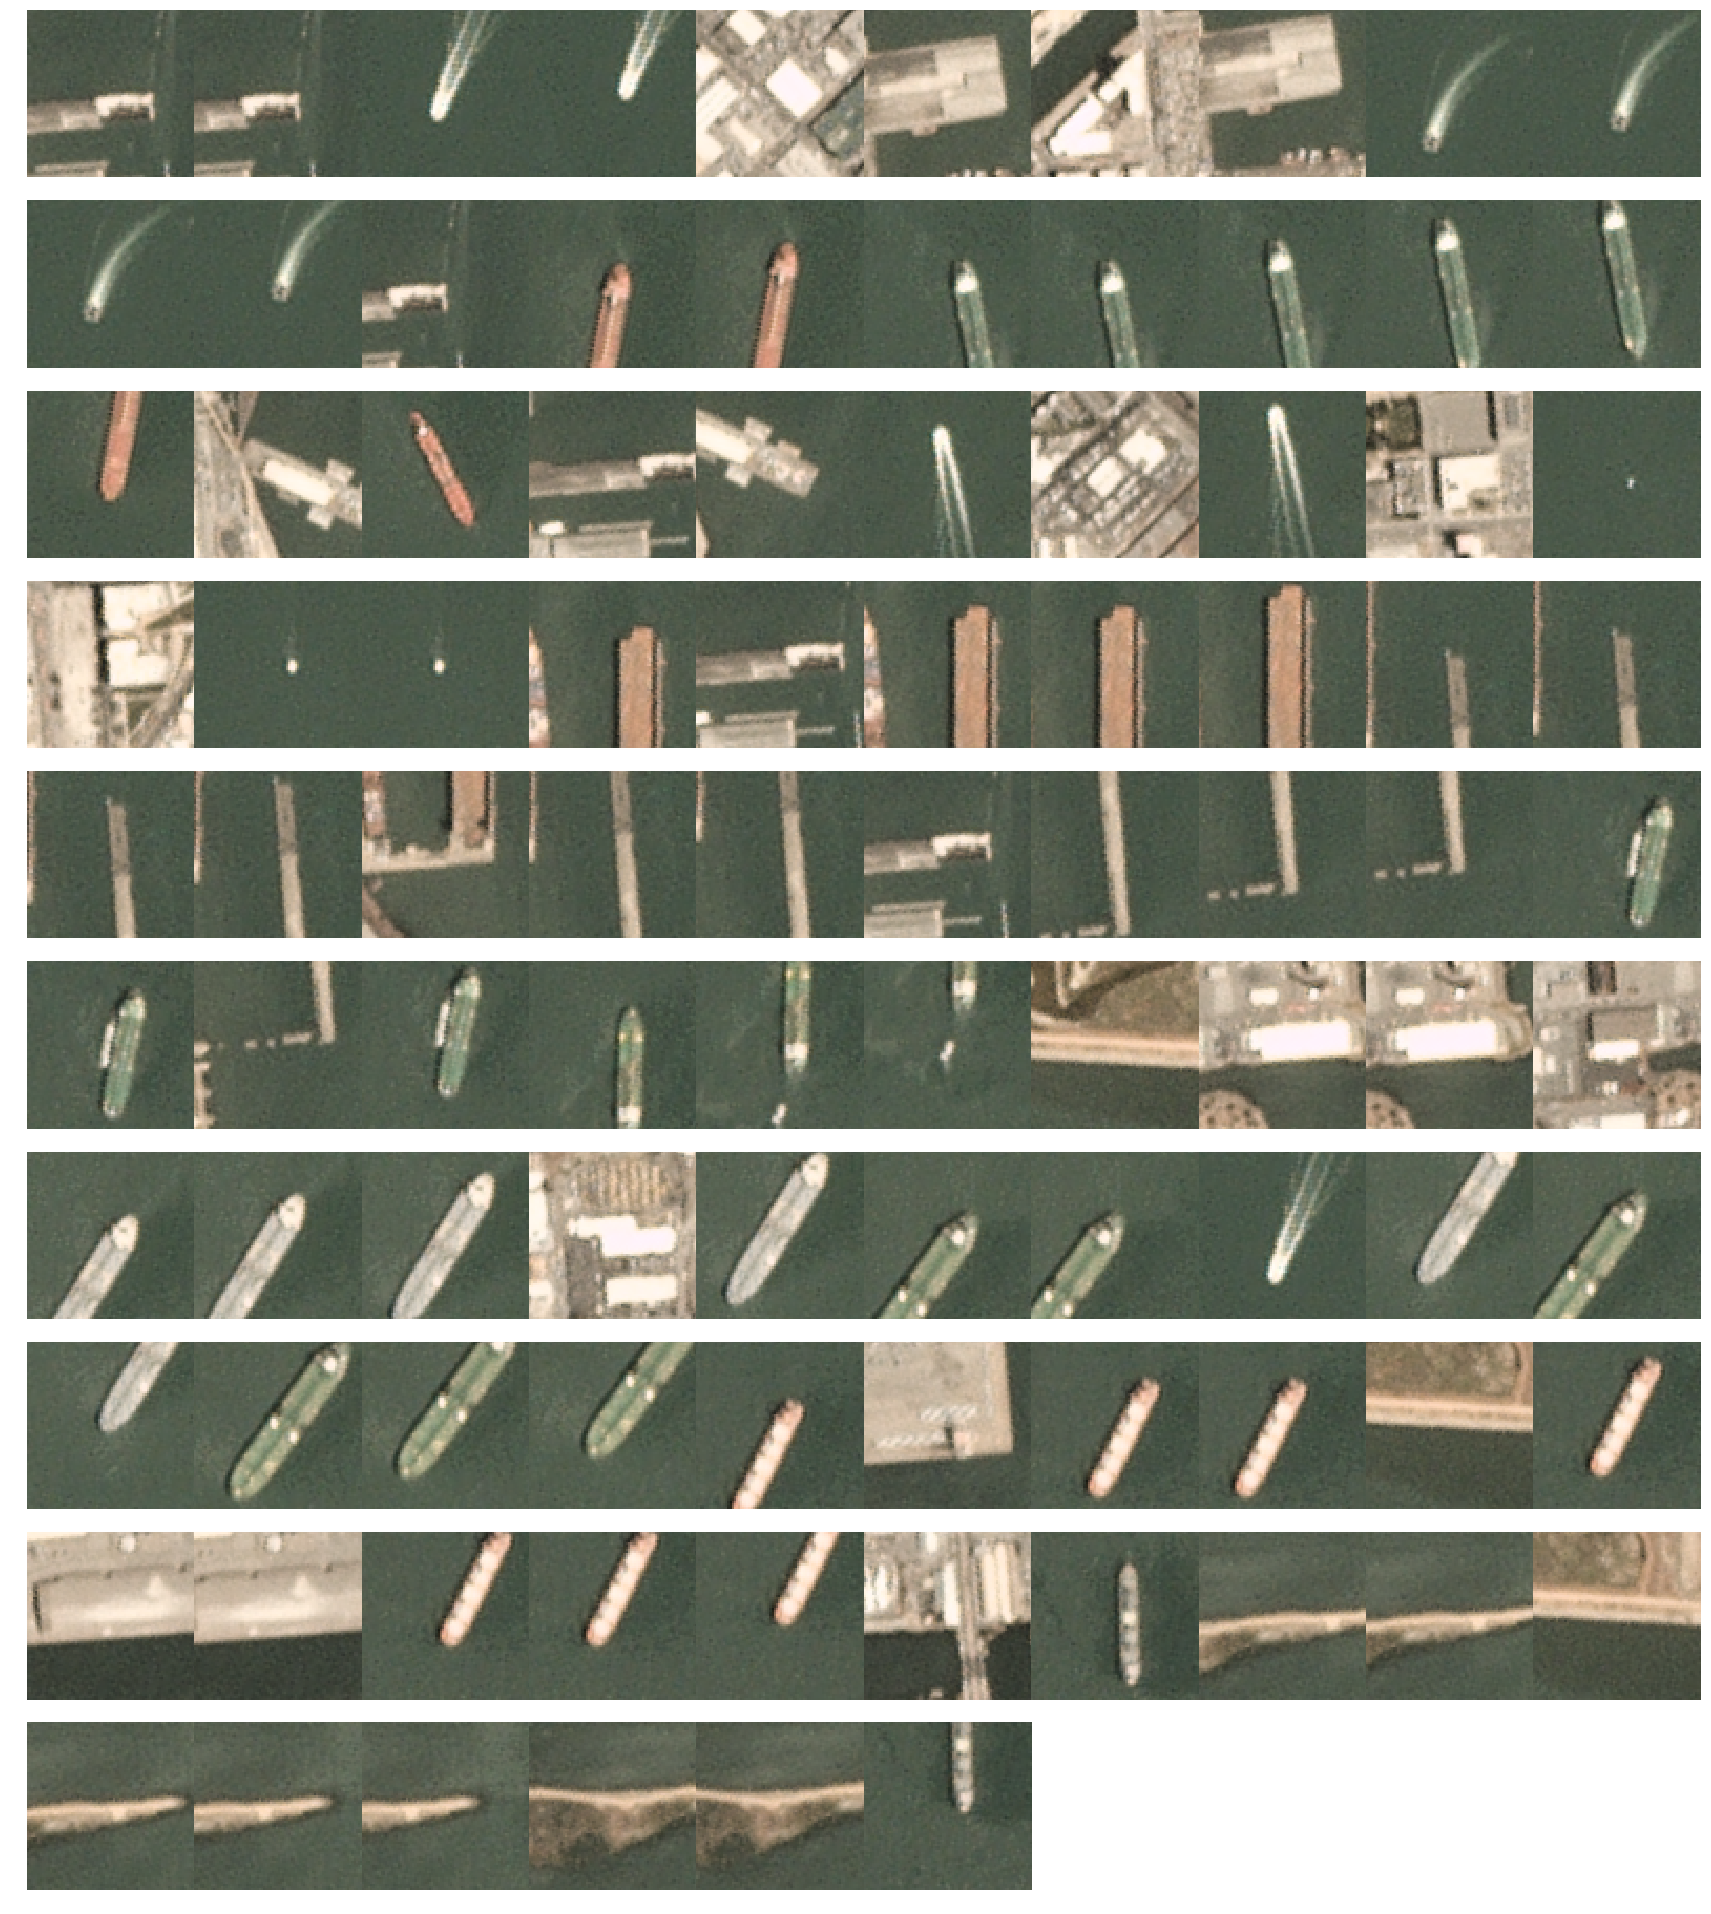

In [6]:
### windows detected as ships by classifer 1

import glob

rimages = []

for img in glob.glob("./results/capstoneP4/winimg1/*.png"):
    rimages.append(plt.imread(img))
    
plt.figure(figsize=(30,35))
columns = 10
for i, image in enumerate(rimages):
    plt.subplot(len(rimages) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.subplots_adjust(hspace=0)

As shown, the classifer can correctly identify all ships but there are several instances that it produce a false positive result like identifying several landcover that resemble a ship and some buildings. 

This might be due to the fact that the model is still overfitted and more dropouts might be needed in the layers. Recall that my previous assumption of not including the dropout in all layer so as to allow the ConvNet to extract more feature has backfire. In this case, more dropout and any other form of regularization are need.

Another reason is that we do not have enough dataset for training. Also, we have an imbalanced dataset with 25% of the data are ships and 75% of the data non ships. However, since the test case is on a full satellite image, the number of ships appearance within the satellite image is small compared to other landcovers. Therefore, more data can be included to train the ConvNet to land more feature of the other landcovers and tell it is not a ship. This comes with more experimentation with more generated dataset.

One way to reduce the overfitting was to use negative hard mining technique where incorrect classified data are further included in the training.
Another way is through the used of data augumentation to generate more dataset for training.

This show clear that classifer 2 had been overfitted and therefore, leading several false positive showing up. It even miss some of the small boats but majority of the ship is present.

In [139]:
### The mysterious case of unshuffled data and dropout at each layers of model 1 (Classifer 1)
### so far the best results!!!

### Future work

To validate further the model more test set can be generated daily from Planet Labs. With each new satellite image, negative hard mining can be employed to locate false positive and feed back into the training of the ConvNet classifer.

Links that help me along the way:

https://www.pyimagesearch.com/ -- excellant tutorial on image processing
http://cs231n.stanford.edu/ --  understanding ConvNet
https://machinelearningmastery.com/category/deep-learning/ -- lots of deep learning information

In [1]:
### Submission
## Capstone Part 4
## train.py --- script for training a bunch of model sequentially